# **Kaggle: Car Price Prediction Challenge**

In this notebook, i'm going to going to train a model to predict the price of a car, using the [Car Price Prediction Challenge](https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge) from Kaggle dataset.

In [347]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders.ordinal import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 

Before starting, let's read the dataset.

In [348]:
df = pd.read_csv('car_price_prediction.csv')

df

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,45798355,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19233,45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
19234,45804997,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
19235,45793526,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.0,Automatic,Front,04-May,Left wheel,Black,4


**Attributes**

First of all let's see all the possible values that each attribute can take to see if there are any mistake due to the format of the dataset.

In [349]:
for column in df.columns:
    print(f"'{column}':")
    print(df[column].unique())
    print("\n")

'ID':
[45654403 44731507 45774419 ... 45804997 45793526 45813273]


'Price':
[13328 16621  8467 ... 56814 63886 22075]


'Levy':
['1399' '1018' '-' '862' '446' '891' '761' '751' '394' '1053' '1055'
 '1079' '810' '2386' '1850' '531' '586' '1249' '2455' '583' '1537' '1288'
 '915' '1750' '707' '1077' '1486' '1091' '650' '382' '1436' '1194' '503'
 '1017' '1104' '639' '629' '919' '781' '530' '640' '765' '777' '779' '934'
 '769' '645' '1185' '1324' '830' '1187' '1111' '760' '642' '1604' '1095'
 '966' '473' '1138' '1811' '988' '917' '1156' '687' '11714' '836' '1347'
 '2866' '1646' '259' '609' '697' '585' '475' '690' '308' '1823' '1361'
 '1273' '924' '584' '2078' '831' '1172' '893' '1872' '1885' '1266' '447'
 '2148' '1730' '730' '289' '502' '333' '1325' '247' '879' '1342' '1327'
 '1598' '1514' '1058' '738' '1935' '481' '1522' '1282' '456' '880' '900'
 '798' '1277' '442' '1051' '790' '1292' '1047' '528' '1211' '1493' '1793'
 '574' '930' '1998' '271' '706' '1481' '1677' '1661' '1286' '1408' '109

Looking at the values, we can see that some samples in the "Levy" column have a value of '-'. Since this doesn't make sense as an indicator that the car doesn't have a levy, it will be replaced with NaN to represent that the levy value is unknown.

Another attribute that has values that don't make sense is 'Doors', that takes the value 04-May or 02-Mar due to the format that takes the csv, so it will be changed from the 04-May to 5 doors and the 02-Mar to 3 doors.

We can also see that some samples in the "Mileage" column have a value of '0 km' that will be replaced with NaN to represent that the mileage is unknown, because is impossible to a car have 0 km if it is an old.

Same as Milege, we can see some samples in "Airbags" that have a value of 0 that will be replaced with NaN to represent that the airbags value is unknown.

And finally let's eliminate the column 'ID' because it doesn't help us in the prediction of the price of the car.

In [350]:
df['Levy'] = df['Levy'].replace('-',np.nan)
df['Doors'] = df['Doors'].replace('04-May', 5)
df['Doors'] = df['Doors'].replace('02-Mar', 3)
df['Mileage'] = df['Mileage'].replace('0 km', np.nan)
df['Airbags'] = df['Airbags'].replace(0, np.nan)
df = df.drop('ID', axis=1)

df

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,5,Left wheel,Silver,12.0
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,5,Left wheel,Black,8.0
2,8467,NaN,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,5,Right-hand drive,Black,2.0
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,5,Left wheel,White,NaN
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,5,Left wheel,Silver,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,NaN,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,3,Left wheel,Silver,5.0
19233,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,5,Left wheel,Red,8.0
19234,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,5,Left wheel,Grey,4.0
19235,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.0,Automatic,Front,5,Left wheel,Black,4.0


To continue, let's see the types of each attribute of the dataset.

In [351]:
df.dtypes

Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags             float64
dtype: object

The attribute Levy is of type object because of the '-' it has after.
The attribute Mileage is of type object because of the ' km'.

For that, let's change the type of the this attributes to numeric

In [352]:
df['Levy'] = df['Levy'].astype('float64')
df['Mileage'] = df['Mileage'].str.replace(' km', '').astype('float64')

df.dtypes

Price                 int64
Levy                float64
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage             float64
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags             float64
dtype: object

Here is the table with the attributes of the dataset:

| Variable            | Definition                                | Key                                                     | Type        |
|---------------------|-------------------------------------------|---------------------------------------------------------|-------------|
| ```Price```               | Price of the vehicle                      |                                                         | Numeric     |
| ```Levy```                | Tax/levy cost associated with the vehicle |                                                         | Numeric     |
| ```Manufacturer```        | Manufacturer of the vehicle               |                                                         | Categoric   |
| ```Model```               | Model of the vehicle                      |                                                         | Categoric   |
| ```Prod. year```          | Production year of the vehicle            |                                                         | Numeric     |
| ```Category```            | Category of the vehicle                   |                     | Categoric   |
| ```Leather interior```    | Presence of leather interior              | Yes, No                                                 | Binary      |
| ```Fuel type```        | Type of fuel used                         | Petrol, Diesel, Hybrid, CNG, LPG, Hydrogen, Plug-in Hybrid            | Categoric   |
| ```Engine volume```       | Engine capacity in liters                 |                                                         | Categoric     |
| ```Mileage```       | Total mileage of the vehicle              |                                   | Numeric     |
| ```Cylinders```           | Number of cylinders in the engine         |                                                         | Numeric     |
| ```Gear box type```      | Type of gearbox                           | Automatic, Manual, Tiptronic, Variator                              | Categoric   |
| ```Drive wheels```        | Type of drive wheels                      | Front, Rear, 4W4                             | Categoric   |
|```Doors```           | Number of doors                           | 3, 5, >5                                           | Categoric     |
|```Wheel```              | Steering wheel side                       | Left, Right                                    | Categoric   |
|```Color```             | Color of the vehicle                      |                                                         | Categoric   |
| ```Airbags```           | Number of airbags                         |                                                         | Numeric     |

The next step after check all the attributes are correct is dividing the dataset into train and test sets, with 80% of the dataset in the train set and 20% in the test set.

In [353]:
y=df['Price']
X=df.drop('Price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

Let's see the percentage of NaNs the train dataset has.

In [354]:
percent_nan_col = train.isna().mean(axis=0)
percent_nan_col

Levy                0.300994
Manufacturer        0.000000
Model               0.000000
Prod. year          0.000000
Category            0.000000
Leather interior    0.000000
Fuel type           0.000000
Engine volume       0.000000
Mileage             0.037754
Cylinders           0.000000
Gear box type       0.000000
Drive wheels        0.000000
Doors               0.000000
Wheel               0.000000
Color               0.000000
Airbags             0.126714
Price               0.000000
dtype: float64

Now let's see if there are any correlation between the attributes of the train set and the target ```Price```, doing it like this we are going to avoid data leakage. Firtsly the correlations will be from the numeric attributes without the NaNs.

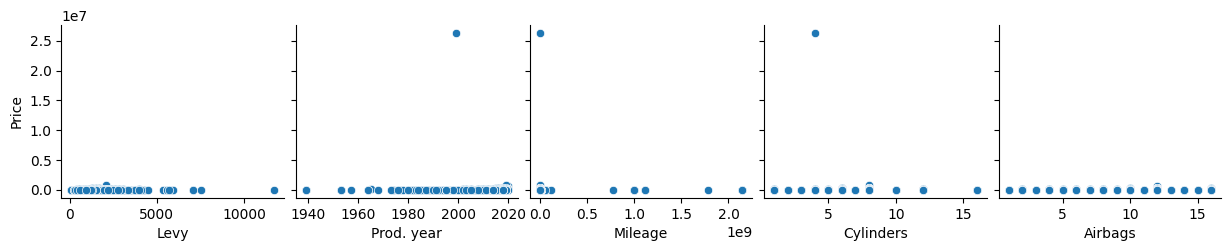

In [355]:
g= sns.pairplot(train,y_vars=['Price'], x_vars=df.select_dtypes(include='number').columns.drop('Price'), dropna=True)

This pairplot shows that there are at least one sample that is an outlier, let's see the distribution the dataset has before fixing it.

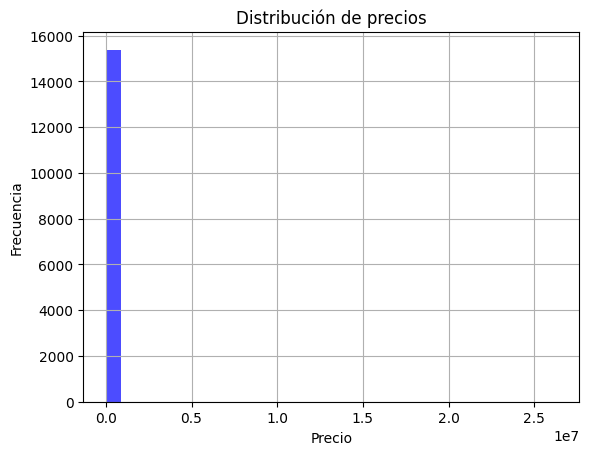

In [356]:
train['Price'].hist(bins=30, color='blue', alpha=0.7)
plt.title('Distribución de precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()


In this histogram we can see that there are one sample that has a useless value to us, the price of it is more than 26e6 and the next bigger price is less than 1e6, so let's remove it before see the distribution.

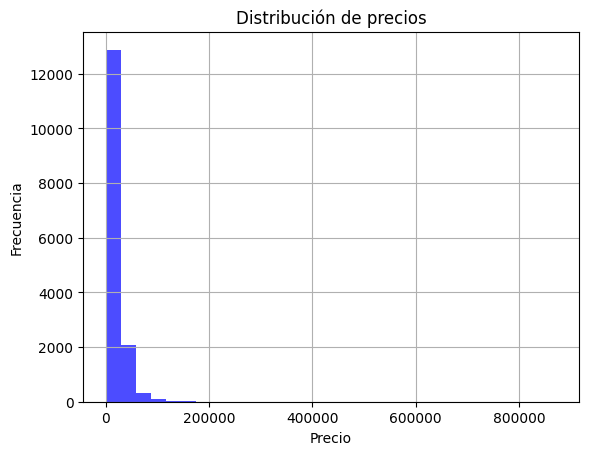

In [357]:
train = train.drop(index=train['Price'].idxmax())

train['Price'].hist(bins=30, color='blue', alpha=0.7)
plt.title('Distribución de precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

The train set distribution is asimetric between less than 100€ and more than 800€, so let's combine the percentile and quantile method to fix the train set.

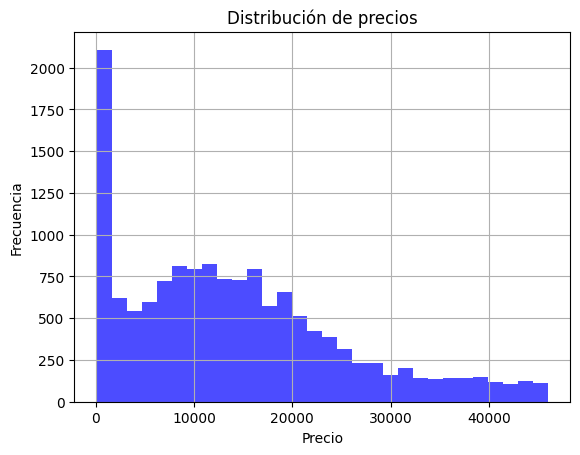

In [358]:
lower_percentile = train['Price'].quantile(0.02)
upper_percentile = train['Price'].quantile(0.98)

train = train[(train['Price'] >= lower_percentile) & (train['Price'] <= upper_percentile)]

Q1=train['Price'].quantile(0.25)
Q3=train['Price'].quantile(0.75)
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR

train = train[(train['Price'] >= lower_bound) & (train['Price'] <= upper_bound)]

train['Price'].hist(bins=30, color='blue', alpha=0.7)
plt.title('Distribución de precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

Before continue, the test dataset must have the same outliers processing as the train dataset.

In [359]:
test = test[(test['Price'] >= lower_percentile) & (test['Price'] <= upper_percentile)]
test = test[(test['Price'] >= lower_bound) & (test['Price'] <= upper_bound)]

Now finally, let's see the correlations between the attributes and the target. 

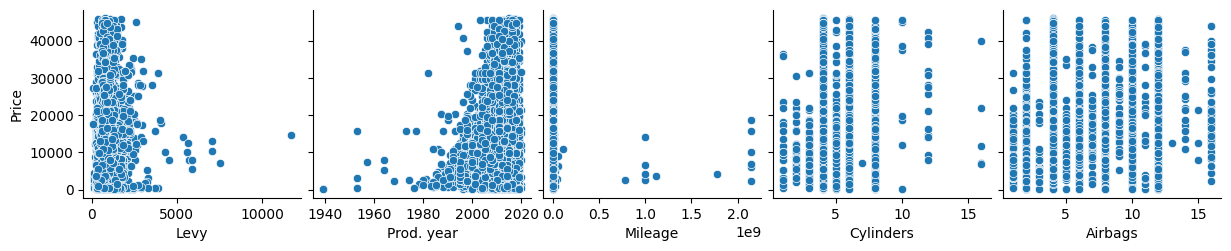

In [360]:
sns.pairplot(train,y_vars=['Price'], x_vars=df.select_dtypes(include='number').columns.drop('Price'), dropna=True)

<Axes: >

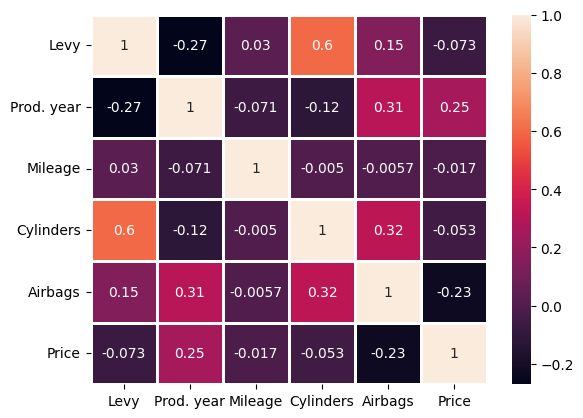

In [361]:
sns.heatmap(train.corr(numeric_only=True),annot=True,linewidths=2)

In both graphics, the most correlated numerics attributes with the target is ```Prod. year``` and ```Airbags```, the other ones have less than 0.1

Before select the best features, let's do a NaN's treatment to the train set and look to the correlations again.

In [362]:
train['Levy']=train['Levy'].fillna(train['Levy'].mean())
train['Mileage']=train['Mileage'].fillna(train['Mileage'].mean())
test['Airbags']=test['Airbags'].fillna(test['Airbags'].mean())

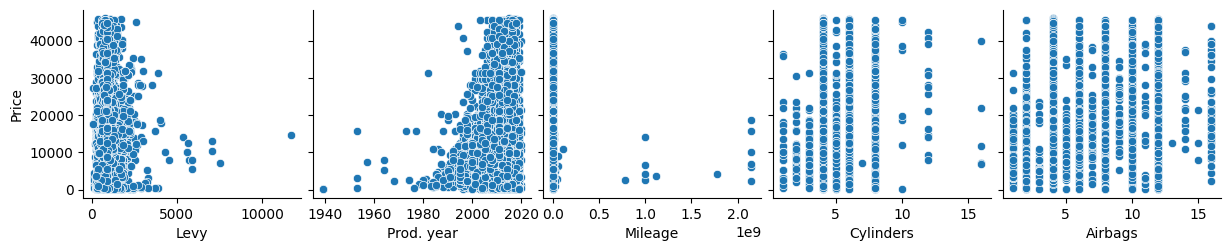

In [363]:
g= sns.pairplot(train,y_vars=['Price'], x_vars=df.select_dtypes(include='number').columns.drop('Price'), dropna=True)

<Axes: >

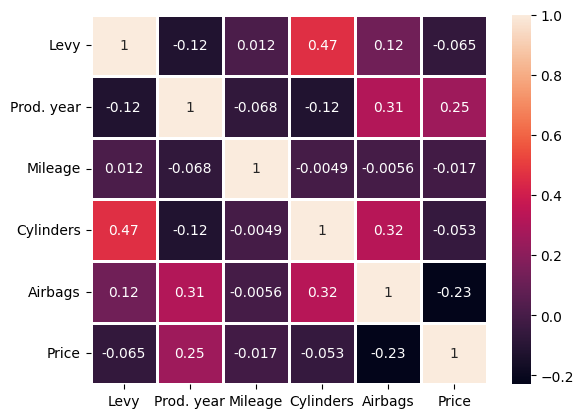

In [364]:
sns.heatmap(train.corr(numeric_only=True),annot=True,linewidths=2)

The correlation keep being the same, so let's continue.

The next step is encode and normalize the categoric atributes, the correct way to do it is in train and test at the same time, so let's join them before.

In [365]:
n_train = train.shape[0]
df = pd.concat([train, test], axis=0)